In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (davies_bouldin_score, silhouette_score, calinski_harabasz_score)
import matplotlib.pyplot as plt
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns=200
pd.options.display.max_colwidth=200

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
deleteFeatures = False
useBisRow = 30000
eps = 0.5
min_samples = 50

# EDA

In [112]:
dt =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/UNSW-NB15_1.csv', header = None, dtype={1: 'object'})
dt.columns = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/NUSW-NB15_features.csv',encoding='cp1252').Name

In [113]:
data = dt [0:useBisRow]
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/anomaly_labels.csv')
labels.Label = [-x if x == 1 else 0 for x in labels.Label ]
anomaly_labels = labels.Label[0:useBisRow]

In [114]:
Counter(data["Label"]).keys()

dict_keys([0, 1])

In [115]:
Counter(data["Label"]).values()

dict_values([27617, 2383])

In [116]:
data['service']= np.where(data['service'] == '-', 'None', data['service'])
data['state']= np.where(data['state'] == 'no', 'None', data['state'])
data['is_sm_ips_ports'] = data['is_sm_ips_ports'].astype(bool)
data['is_ftp_login'] = data['is_ftp_login'].astype(bool)
data['ct_state_ttl'] = data['ct_state_ttl'].astype('category')

In [117]:
if deleteFeatures:
  selected_df = data[['service', 'sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Spkts', 'Dload', 'sloss', 'dloss', 'ct_src_ ltm', 'ct_srv_dst' ]]
  num_cols = selected_df.drop(columns = 'service')
  scaler = MinMaxScaler()
  num_cols = scaler.fit_transform(num_cols)
  num_cols = pd.DataFrame(num_cols)
  num_cols.columns = ['sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 
                            'Spkts', 'Dload', 'sloss', 'dloss', 'ct_src_ ltm', 'ct_srv_dst']
  cat_cols = selected_df['service']
  labelencoder = LabelEncoder()
  le_value = labelencoder.fit_transform(cat_cols)
  cat_cols = le_value
  onehotcols = pd.DataFrame(cat_cols, columns = ['service'])
  encoder= OneHotEncoder()
  onehotcols = encoder.fit_transform(onehotcols).toarray() 
  onehotdf = pd.DataFrame(onehotcols)
  processed_data = pd.concat([onehotdf, num_cols ], axis =1)

else:
  num_cols=data.select_dtypes(include='number')
  num_cols = num_cols.drop(columns='Label', axis=1)
  scaler = MinMaxScaler()
  num_data = scaler.fit_transform(num_cols)  
  num_data = pd.DataFrame(num_data)
  num_data.columns=num_cols.columns

  cat_cols = data.select_dtypes(exclude='number')
  cat_data=cat_cols.drop(['srcip','dstip','sport','dsport', 'attack_cat'], axis=1)
  cat_data['is_ftp_login']=cat_data['is_ftp_login'].astype('category')
  cat_data['is_sm_ips_ports']=cat_data['is_sm_ips_ports'].astype('category')
  data_dummies = pd.get_dummies(cat_data, drop_first=True)
  processed_data = pd.concat([data_dummies, num_data ], axis =1)

data_model_input = processed_data
data_model_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   proto_icmp            30000 non-null  uint8  
 1   proto_igmp            30000 non-null  uint8  
 2   proto_ospf            30000 non-null  uint8  
 3   proto_sctp            30000 non-null  uint8  
 4   proto_tcp             30000 non-null  uint8  
 5   proto_udp             30000 non-null  uint8  
 6   state_ECO             30000 non-null  uint8  
 7   state_FIN             30000 non-null  uint8  
 8   state_INT             30000 non-null  uint8  
 9   state_REQ             30000 non-null  uint8  
 10  state_RST             30000 non-null  uint8  
 11  state_URH             30000 non-null  uint8  
 12  service_dns           30000 non-null  uint8  
 13  service_ftp           30000 non-null  uint8  
 14  service_ftp-data      30000 non-null  uint8  
 15  service_http       

In [118]:
max_calinski = 0

# Full Model¶

In [119]:
# Defining the agglomerative clustering
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

In [120]:
# Fit model
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [121]:
Counter(cluster_preds).keys()

dict_keys([0, 1, -1, 2, 3, 6, 4, 5, 10, 8, 7, 9, 12, 13, 11, 14])

In [122]:
anom_preds = np.where(cluster_preds == -1, -1, 0)

In [123]:
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,1129,1254
0,983,26634


In [124]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.47
Precision: 0.53


In [125]:
## ratio between the within-cluster dispersion and the between-cluster dispersion.
## higher Calinski-Harabasz score relates to a model with better defined clusters.
calinski = calinski_harabasz_score(data_model_input, anom_preds)
calinski

663.4524517727862

In [126]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

663.4524517727862


In [127]:
##  average similarity measure of each cluster with its most similar cluster,
## The minimum score is zero, with lower values indicating better clustering.
davies_bouldin_score(data_model_input, anom_preds)

3.4880613812078076

# Model with Selected Features¶

In [128]:
#service_dummy = pd.get_dummies(data['service'], drop_first=True)
#selected_df = pd.concat([num_data[['sttl', 'sbytes', 'smeansz', 'ct_dst_sport_ltm']], service_dummy], axis=1)
data_model_input = num_data[['sttl', 'sbytes', 'smeansz', 'ct_dst_sport_ltm']].copy()

In [129]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [130]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,0,27617


In [131]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.00
Precision: 1.00


In [132]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)
calinski

75.28090756376191

In [133]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [134]:
davies_bouldin_score(data_model_input, anom_preds)

0.19489536835421378

# Model 1

In [135]:
data_model_input = num_data[['sbytes', 'sttl']].copy()

In [136]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [137]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,0,27617


In [138]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.00
Precision: 1.00


In [139]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)
calinski

54.28116269369585

In [140]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [141]:
davies_bouldin_score(data_model_input, anom_preds)

0.22421459362817678

# Model 2

In [142]:
data_model_input = num_data[['sbytes', 'sttl', 'dttl']].copy()

In [143]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [144]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,0,27617


In [145]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.00
Precision: 1.00


In [146]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)
calinski

48.04443470107599

In [147]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [148]:
davies_bouldin_score(data_model_input, anom_preds)

0.22127642082459778

# Model 3

In [149]:
data_model_input = num_data[['sbytes', 'sttl','tcprtt','synack']].copy()

In [150]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [151]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,3,27614


In [152]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.00
Precision: 0.57


In [153]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)
calinski

84.90071459134832

In [154]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [155]:
davies_bouldin_score(data_model_input, anom_preds)

1.1176574144809694

# Model 4

In [156]:
data_model_input = num_data[['sbytes', 'sttl','tcprtt','synack', 'ackdat']].copy()

In [157]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [158]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,5,27612


In [159]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.00
Precision: 0.44


In [160]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)
calinski

134.54489044635503

In [161]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [162]:
davies_bouldin_score(data_model_input, anom_preds)

1.0567071616623225

# Model 5

In [163]:
data_model_input = num_data[['sbytes', 'sttl','tcprtt','synack', 'ackdat', 'Sload']].copy()

In [164]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [165]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,10,2373
0,5,27612


In [166]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.00
Precision: 0.67


In [167]:
if len(Counter(cluster_preds).keys()) > 1:
  calinski = calinski_harabasz_score(data_model_input, anom_preds)
  calinski

In [168]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [169]:
if len(Counter(cluster_preds).keys()) > 1:
  davies_bouldin_score(data_model_input, anom_preds)

# Hyperparameter Tuning

In [170]:
best_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   proto_icmp            30000 non-null  uint8  
 1   proto_igmp            30000 non-null  uint8  
 2   proto_ospf            30000 non-null  uint8  
 3   proto_sctp            30000 non-null  uint8  
 4   proto_tcp             30000 non-null  uint8  
 5   proto_udp             30000 non-null  uint8  
 6   state_ECO             30000 non-null  uint8  
 7   state_FIN             30000 non-null  uint8  
 8   state_INT             30000 non-null  uint8  
 9   state_REQ             30000 non-null  uint8  
 10  state_RST             30000 non-null  uint8  
 11  state_URH             30000 non-null  uint8  
 12  service_dns           30000 non-null  uint8  
 13  service_ftp           30000 non-null  uint8  
 14  service_ftp-data      30000 non-null  uint8  
 15  service_http       

In [171]:
params = {'eps': [0.2, 0.3, 0.5],
         'min_samples': range(50, 200, 10)}

score_table = pd.DataFrame(columns=['Epsilon', 'Min Sample Size',
                                    'Calinski Harabasz Score', 'Davies Bouldin Score', "Recall", "Precision", 'Num Anomalies Found'])
max_calinski = 0
best_eps = 0.5
best_min_samples = 10
data_model_input = best_data

for eps in params['eps']:
    for min_samples in params['min_samples']:
      try:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_preds = dbscan_model.fit_predict(data_model_input)  
        print(cluster_preds.tolist().count(-1))
        anom_preds = np.where(cluster_preds == -1, -1, 0)     
        calinski = calinski_harabasz_score(data_model_input, anom_preds)                  
        if calinski > max_calinski:
          max_calinski = calinski
          best_eps = eps
          best_min_samples = min_samples
        davies = davies_bouldin_score(data_model_input, anom_preds)
        contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )
        recall = contingency.iloc[0,0] / (contingency.iloc[0,0]+contingency.iloc[0,1])
        precision = contingency.iloc[0,0]/ (contingency.iloc[0,0]+contingency.iloc[1,0])
        score_table=score_table.append({'Epsilon':eps, 
                                      'Min Sample Size':min_samples,
                                      'Calinski Harabasz Score':calinski, 
                                      'Davies Bouldin Score':davies,
                                      'Recall':recall,
                                      'Precision':precision,
                                      'Num Anomalies Found':cluster_preds.tolist().count(-1)}, 
                                      ignore_index=True)
      except:
        print("Exception")
        
print('best_eps:', best_eps)
print('best_min_samples:', best_min_samples)
display(score_table)

23325
23361
23406
23543
23583
23627
23663
23716
23796
24013
24071
24158
24194
24350
24488
11601
13869
15531
16481
17423
18645
19925
20928
21601
22416
22734
22980
22982
22989
23010
2112
2597
2746
2914
2977
3040
3156
3478
3601
3759
4063
4192
4566
5003
5203
best_eps: 0.3
best_min_samples: 160


,Epsilon,Min Sample Size,Calinski Harabasz Score,Davies Bouldin Score,Recall,Precision,Num Anomalies Found
0,0.2,50.0,22644.465751,0.761444,0.935795,0.095606,23325.0
1,0.2,60.0,22395.342558,0.762863,0.935795,0.095458,23361.0
2,0.2,70.0,22093.209868,0.763414,0.940831,0.095787,23406.0
3,0.2,80.0,21245.932970,0.761898,0.958456,0.097014,23543.0
4,0.2,90.0,20990.346670,0.762914,0.960134,0.097019,23583.0
5,0.2,100.0,20714.961816,0.763907,0.961813,0.097008,23627.0
6,0.2,110.0,20499.426780,0.764761,0.963072,0.096987,23663.0
7,0.2,120.0,20172.710687,0.765765,0.968107,0.097276,23716.0
8,0.2,130.0,19711.498824,0.766226,0.973563,0.097495,23796.0
9,0.2,140.0,18586.380471,0.759952,1.000000,0.099238,24013.0


# Best Model

In [172]:
dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
cluster_preds = dbscan_model.fit_predict(best_data)
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,2222,161
0,20758,6859


In [173]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.93
Precision: 0.10


In [174]:
calinski_harabasz_score(best_data, anom_preds)

25272.44092596387

In [175]:
davies_bouldin_score(best_data, anom_preds)

0.7471700832870785

# Results with PCA

In [182]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(processed_data)

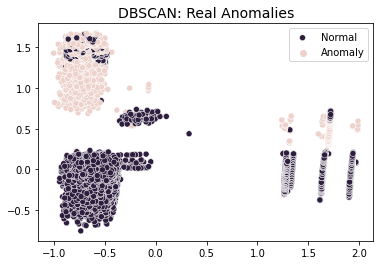

In [183]:
sns.scatterplot(x=pca_components[:, 0],y= pca_components[:, 1], hue=anomaly_labels)
plt.title('DBSCAN: Real Anomalies', fontsize=14)
plt.legend(labels=['Normal', 'Anomaly'])

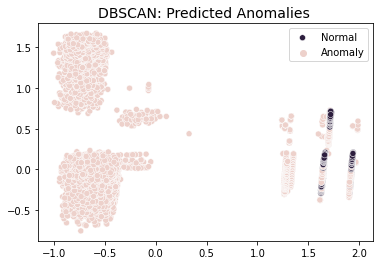

In [178]:
sns.scatterplot(x=pca_components[:, 0],y= pca_components[:, 1], hue=anom_preds)
plt.title('DBSCAN: Predicted Anomalies ', fontsize=14)
plt.legend(labels=['Normal', 'Anomaly'])

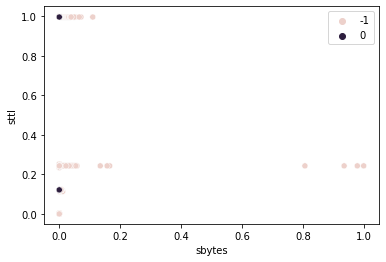

In [179]:
sns.scatterplot(processed_data.sbytes, processed_data.sttl, hue=anom_preds)